In [1]:
from struct import unpack, calcsize
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

#params_pattern defines the structure we want to read in 
params_pattern = '=IBdddd' # (num_samples, sample_bytes, v_off, v_scale, h_off, h_scale, [samples]) ...
struct_size = calcsize(params_pattern)
#print(struct_size)

#Function to unpack the header
def unpackHeader(header):
    sHeader = unpack(params_pattern,header)
    numSamples=sHeader[0]
    bytesPerSample=sHeader[1]
    v_off=sHeader[2]
    v_scale=sHeader[3]
    h_off=sHeader[4]
    h_scale=sHeader[5]
    return numSamples,bytesPerSample,v_off,v_scale,h_off,h_scale

In [2]:
#Just some timing call for debugging
startTime = time.process_time()

#Now the main loop which is looping over both the cathode file and the anode file
with open("width100ns_0_100mV_ampScan.ch4.traces","rb") as fCat, open("width100ns_0_100mV_ampScan.ch3.traces","rb") as fAn:
    ampList=[]
    sigList=[]
    while True:
        #First read and unpack the headers
        header = fCat.read(struct_size)
        headerAn = fAn.read(struct_size)
        if not header: break
        numSamples,bytesPerSample,v_off,v_scale,h_off,h_scale=unpackHeader(header) 
        if not headerAn: break
        numSamplesAn,bpsAn,v_off_an,v_scale_an,h_off_an,h_scale_an=unpackHeader(headerAn)
        
        #Now read in the waveform samples
        dataType=np.dtype('>i1')
        dataList=np.fromfile(fCat,dataType,numSamples)
        anDataList=np.fromfile(fAn,dataType,numSamplesAn)

        #Convert to volts and seconds and subtract a baseline
        voltList=dataList*v_scale
        #voltList-=v_off
        baseline=np.mean(voltList[100:8000])
        voltList-=baseline
        voltListAn=anDataList*v_scale_an
        #voltListAn-=v_off_an
        baseline=np.mean(voltListAn[100:8000])
        voltListAn-=baseline
        ampList.append(-voltListAn) #for simplicity I turn the amp response up side down
        sigList.append(voltList)

    #Now convert the list of numpy array in to a fully feldged 2D array
    sigList=np.vstack(sigList)    
    ampList=np.vstack(ampList)

    #Make an array of time values (assumimg they are all the same sample rates in the file)
    sampList=np.arange(numSamples)
    timeList=sampList*h_scale
    timeList-=h_off
    timeList*=1e6 #Convert to microseconds
    
    #Finish time for optimisation purposes
    endTime = time.process_time()
    print("Process time was "+str(endTime-startTime))

Process time was 0.46875


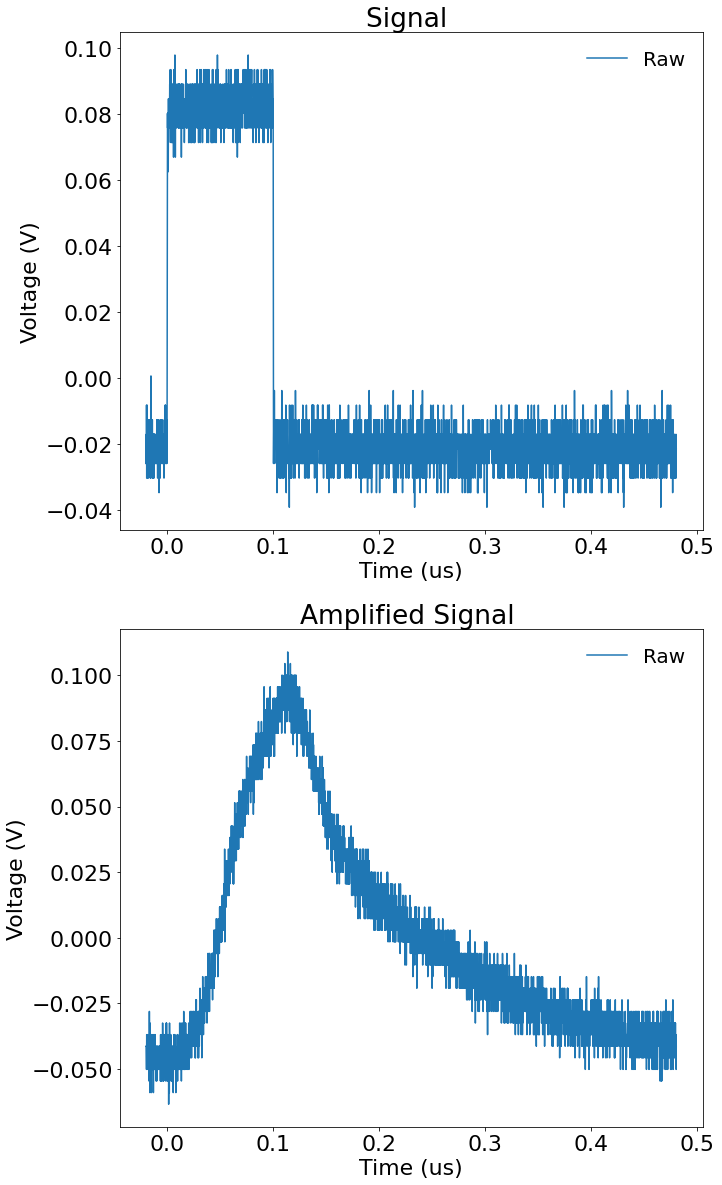

In [3]:
#Plot the raw waveforms
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList,sigList[0],label="Raw")
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title('Signal ')    
ax[0].legend(fontsize=20,loc='upper right')

ax[1].plot(timeList,ampList[0],label="Raw")
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title('Amplified Signal ')
ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

In [4]:
ampList_t = ampList.T
sigList_t = sigList.T

In [5]:
#averaging over all the waveforms
from statistics import mean

aveampList=[]
avesigList=[]

for i in range (ampList_t.shape[0]):
    aveampList.append(mean(ampList_t[i]))
    avesigList.append(mean(sigList_t[i]))

In [6]:
aveampList=np.array(aveampList)
avesigList=np.array(avesigList)

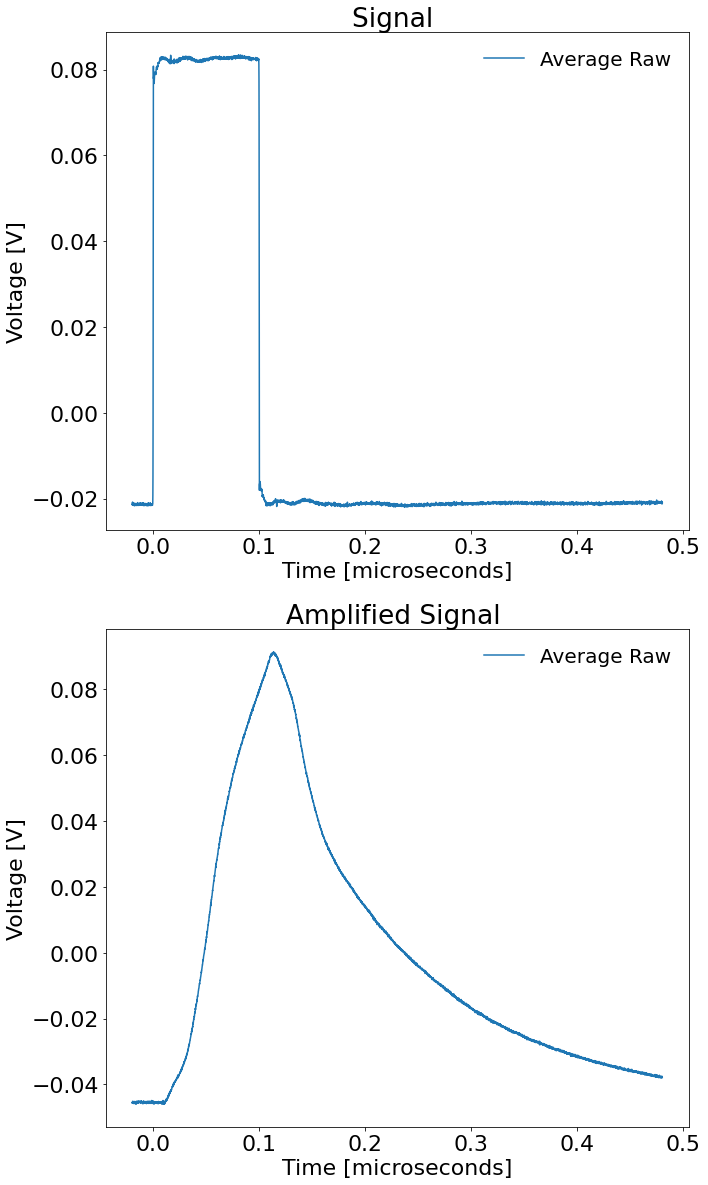

In [184]:
#Plot the raw waveforms
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList,avesigList,label="Average Raw")
ax[0].set_xlabel('Time [microseconds]')
ax[0].set_ylabel('Voltage [V]')
ax[0].set_title('Signal ')    
ax[0].legend(fontsize=20,loc='upper right')

ax[1].plot(timeList,aveampList,label="Average Raw")
ax[1].set_xlabel('Time [microseconds]')
ax[1].set_ylabel('Voltage [V]')
ax[1].set_title('Amplified Signal ')
ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

In [8]:
#we are now interesting in studying the first part of the response of the pre amp

peak_pre_amp=max(aveampList)
peak_pre_amp_pos=np.argmax(aveampList)

#create new curve up to the peak

shortaveampList = []
shorttimeList = []

for i in range (peak_pre_amp_pos):
    shortaveampList.append(aveampList[i])
    shorttimeList.append(timeList[i])

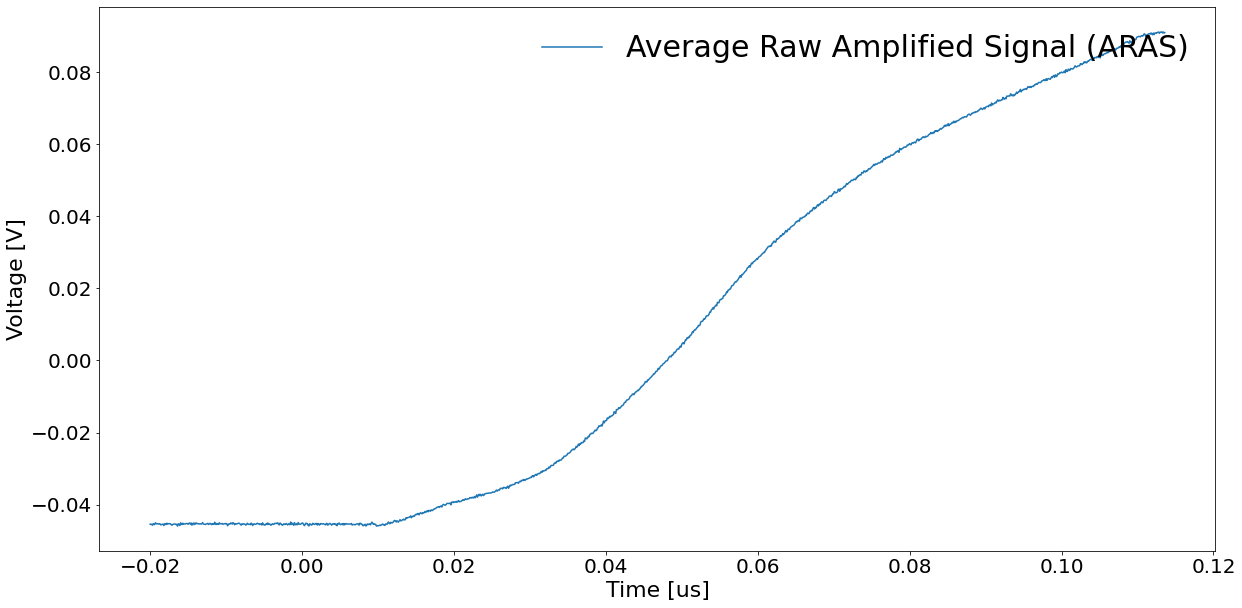

In [9]:
plt.figure(figsize=(20,10))
plt.plot(shorttimeList,shortaveampList,label="Average Raw Amplified Signal (ARAS)")
plt.legend(loc="upper right",prop={'size': 30})
plt.xlabel("Time [microseconds]",fontsize=22)
plt.ylabel("Voltage [V]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [10]:
#remove baseline noise

baseline=mean(shortaveampList)
shortaveampList-=baseline

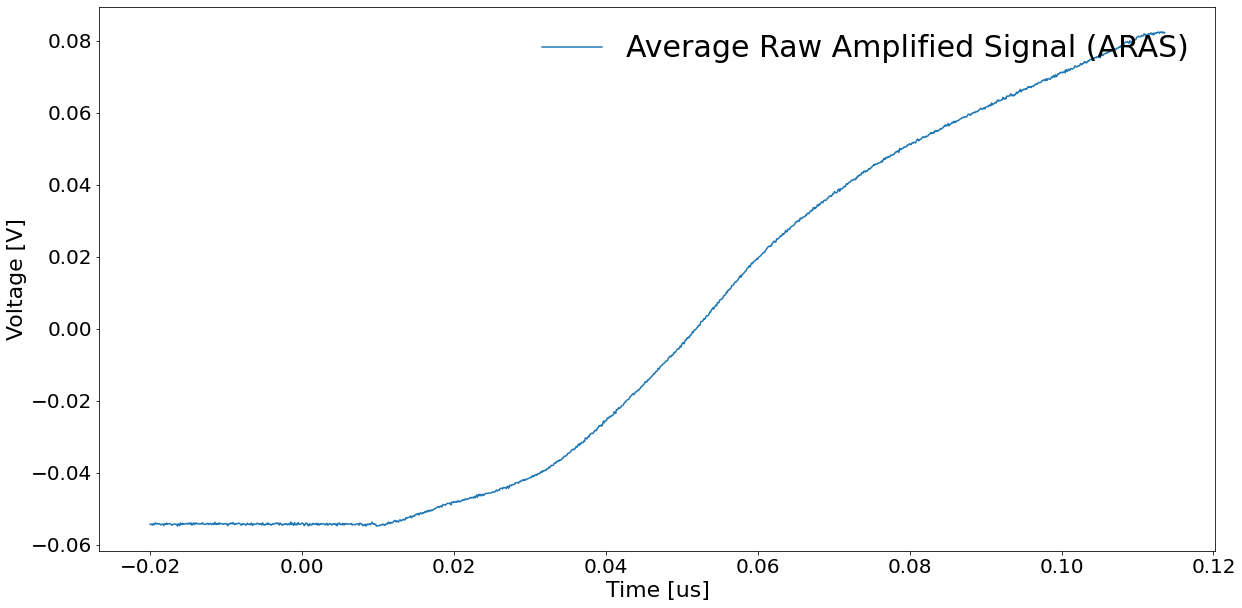

In [11]:
plt.figure(figsize=(20,10))
plt.plot(shorttimeList,shortaveampList,label="Average Raw Amplified Signal (ARAS)")
plt.legend(loc="upper right",prop={'size': 30})
plt.xlabel("Time [microseconds]",fontsize=22)
plt.ylabel("Voltage [V]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [12]:
####it appears difficult to fit the data if the function starts below zero, let move the curve up!

shortaveampList-=min(shortaveampList)

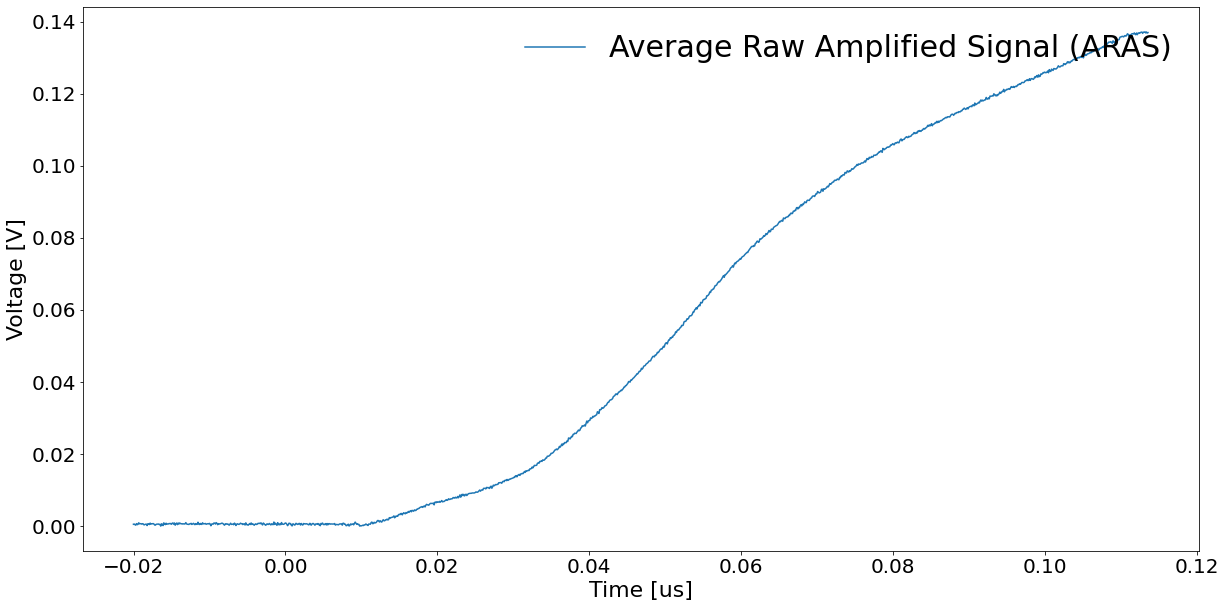

In [13]:
plt.figure(figsize=(20,10))
plt.plot(shorttimeList,shortaveampList,label="Average Raw Amplified Signal (ARAS)")
plt.legend(loc="upper right",prop={'size': 30})
plt.xlabel("Time [microseconds]",fontsize=22)
plt.ylabel("Voltage [V]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [14]:
#####let's fit the curve

# Import curve fitting package from scipy
from scipy.optimize import curve_fit

#define some functions which may become useful during the fitting phase

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

In [45]:
pars, cov = curve_fit(f=exponential, xdata=shorttimeList, ydata=shortaveampList, p0=[1.63597461e-0, 2.06533901e+01], bounds=(0.0001, 30))

In [46]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))

In [47]:
print(pars)

[1.63595663e-02 2.06535123e+01]


In [48]:
print(stdevs)

[0.00040399 0.26616274]


In [49]:
shortaveampList=np.array(shortaveampList)
shorttimeList=np.array(shorttimeList)

In [151]:
twodfit = np.polyfit(shorttimeList,shortaveampList,2)

In [152]:
print(twodfit)

[ 5.89634588e+00  7.11916786e-01 -1.85562643e-04]


In [166]:
trendpoly11d = np.poly1d(elevendfit)

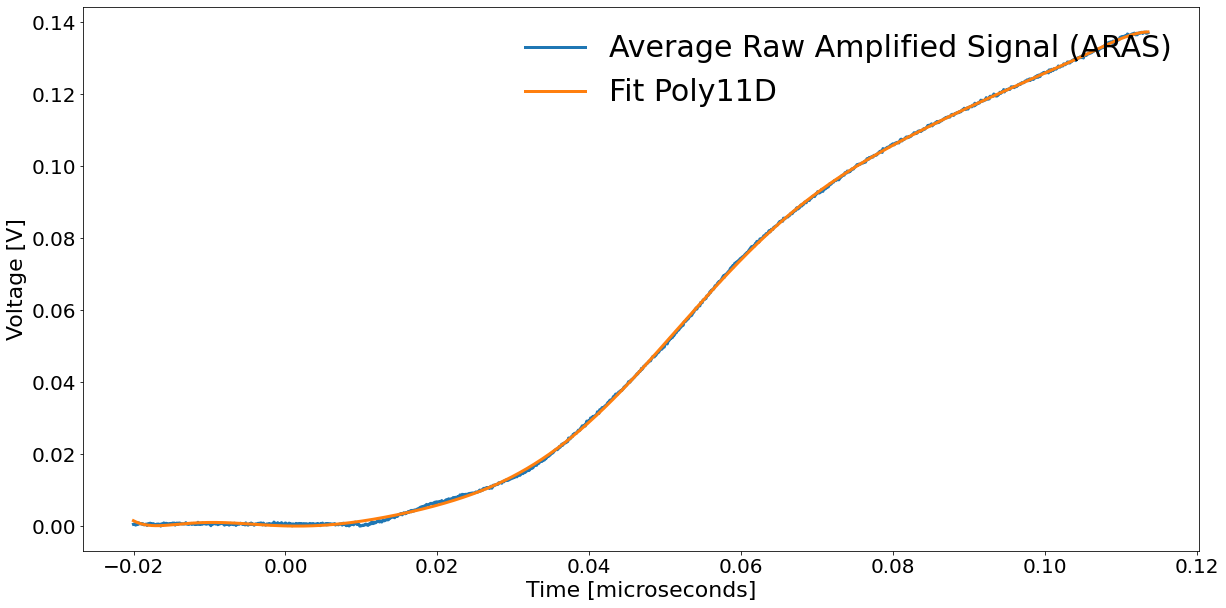

In [183]:
plt.figure(figsize=(20,10))
#plt.plot(x_plot,pion_plus_bis,'r',label='pion plus MC Integration')
#plt.plot(x_plot,pion_minus_bis,'-b',label='pion minus MC Integration')
plt.plot(shorttimeList,shortaveampList,label="Average Raw Amplified Signal (ARAS)",linewidth=3)
#plt.plot(shorttimeList,exponential(shorttimeList, *pars),label="Fit Exponential")
plt.plot(shorttimeList,trendpoly11d(shorttimeList),label="Fit Poly11D",linewidth=3)
plt.legend(loc="upper right",prop={'size': 30})
plt.xlabel("Time [microseconds]",fontsize=22)
plt.ylabel("Voltage [V]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

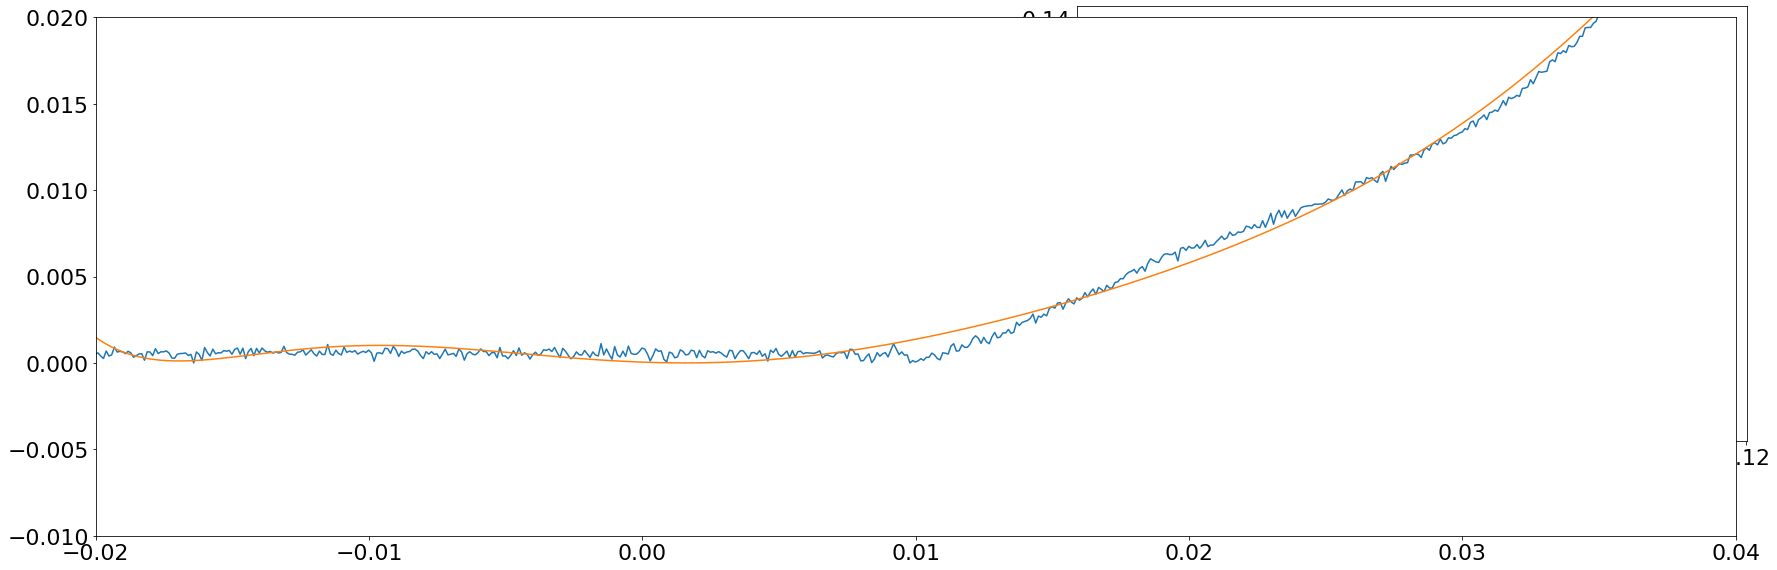

In [136]:
#zooming the area where I am not fitting nicely

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots()

ax.plot(shorttimeList, shortaveampList)
ax.plot(shorttimeList, trendpoly11d(shorttimeList))

axins = zoomed_inset_axes(ax, 6, loc=1) # zoom = 6
axins.plot(shorttimeList, shortaveampList)
axins.plot(shorttimeList, trendpoly11d(shorttimeList))
axins.set_xlim(-0.02, 0.04) # Limit the region for zoom
axins.set_ylim(-0.01, 0.02)

plt.xticks(visible=True)  # Not present ticks
plt.yticks(visible=True)
#
## draw a bbox of the region of the inset axes in the parent axes and
## connecting lines between the bbox and the inset axes area
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.draw()
plt.show()

In [169]:
from scipy import stats
stats.chisquare(shortaveampList, trendpoly11d(shorttimeList)) 

Power_divergenceResult(statistic=1.300131426660956, pvalue=1.0)

In [181]:
from sklearn.metrics import r2_score
r2_score(shortaveampList, trendpoly11d(shorttimeList))

0.9999364371073232

In [ ]:
#let's try Ryan suggestion and convolve an exponential curve with the input.
#the exponential curve should follow the ideal response of a RC circuit

def RC_Circuit_Charging(u, t):
    return (E - u )/(R*C)
    
def RC_Circuit_Discharging(u, t):
    return -u/(R*C)

In [ ]:
####EVERYTHING BELOW THIS LINE IS WORK IN PROGRESS!!!

In [ ]:
import peakutils
shortaveampList = np.array(shortaveampList)
baseline_peakutils = peakutils.baseline(shortaveampList)
shortaveampList = shortaveampList-baseline_peakutils


In [ ]:
from BaselineRemoval import BaselineRemoval

polynomial_degree=2 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(shortaveampList)

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

In [ ]:
baseline=mean(shortaveampList)

In [ ]:
shortaveampList=-baseline

In [ ]:
scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  shorttimeList,  shortaveampList)

In [ ]:
pars, cov = curve_fit(f=power_law, xdata=shorttimeList, ydata=shortaveampList, p0=[-0.04, 0.1], bounds=(-np.inf, np.inf))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(shorttimeList,baseline_peakutils,label="Average Raw Amplified Signal (ARAS)")
plt.legend(loc="upper right",prop={'size': 30})
plt.xlabel("Time [us]",fontsize=22)
plt.ylabel("Voltage [V]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [56]:
def PolyCoefficients(x, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

    The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """
    o = len(coeffs)
    print(f'# This is a polynomial of order {ord}.')
    y = 0
    for i in range(o):
        y += coeffs[i]*x**i
    return y

In [59]:
PolyCoefficients(shorttimeList,z)

# This is a polynomial of order <built-in function ord>.


array([-191.12811212, -191.12484873, -191.12158534, ..., -186.7752619 ,
       -186.77199928, -186.76873667])